I'll be building a convolutional neaural network with the fashion mnist dataset.

It's a more complex dataset than the mnist dataset i used before so I'll have to make some tweaks to the model to enhance it's performance if its predictions aren't to my satisfaction.

Of course i'll use the `TINYVGG` architechture since i havent mastered others yet

In [8]:
# importing dependencies
import torch 
from torch import nn
from torch.utils.data import DataLoader
import torchmetrics
from torchvision import datasets
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import random

In [10]:
# Importing data
train_data = datasets.FashionMNIST(root="data",train=True,transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, transform=ToTensor())
class_names = train_data.classes

In [5]:
# Loading the data into a dataloder
train_dataloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,32,shuffle=False)

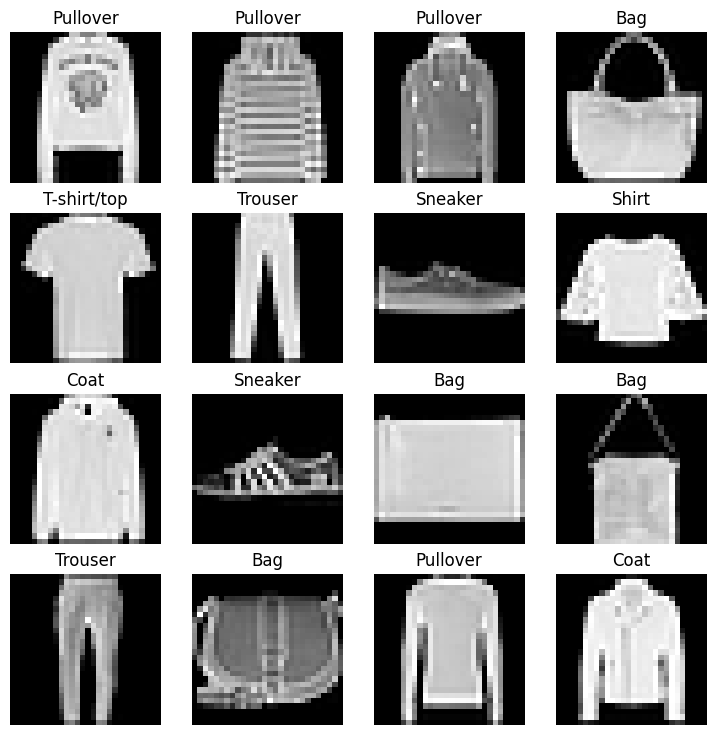

In [17]:
# Visualising the data
fig = plt.figure(figsize=(9,9))
N_COLS,N_ROWS = 4,4
for num in range(1,(N_COLS*N_ROWS)+1):
    rand = random.randint(0, len(train_data))
    img,label = train_data[rand]
    fig.add_subplot(N_ROWS,N_COLS,num)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);
    

In [25]:
# Create model
class FashionMNIST(nn.Module):
    def __init__(self, input_channels, hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.classifiier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifiier(x)
        #print(x.shape)
        return x

model = FashionMNIST(input_channels=1, hidden_units=16, output_shape=len(class_names))

In [26]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params = model.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [50]:
# Build train and test functions for convenience
def train_loop(model:nn.Module, dataloader:torch.utils.data.DataLoader, loss_fn:nn.Module, optim:torch.optim.Optimizer, acc_fn):
    train_loss, train_acc = 0,0
    model.train()
    for X,y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        train_acc += acc_fn(pred.argmax(dim=1), y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")

def test_loop(model:nn.Module, dataloader:torch.utils.data.DataLoader, loss_fn:nn.Module, acc_fn):
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            test_acc += acc_fn(pred.argmax(dim=1), y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%")

def get_model_results(model:nn.Module, dataloader:torch.utils.data.DataLoader, loss_fn:nn.Module, acc_fn):
    test_loss, test_acc = 0,0
    preds = []
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            test_acc += acc_fn(pred.argmax(dim=1), y)
            preds.append(pred.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%")
    y_pred_tensor = torch.cat(preds)    
    return y_pred_tensor

def print_train_time(start,end):
    time = end-start
    print(f'Train time was:{time}')

In [30]:
# Train model
epochs = 3
start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------------")
    train_loop(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optim=optim, acc_fn=acc_fn)
    test_loop(model=model, dataloader=test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn)
end = timer()
print_train_time(start=start,end=end)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------------
Train loss: 0.28787 | Train accuracy: 89.54%
Test loss: 0.30231 | Test accuracy: 88.81%
Epoch: 1
---------------
Train loss: 0.26965 | Train accuracy: 90.28%
Test loss: 0.28949 | Test accuracy: 89.60%
Epoch: 2
---------------
Train loss: 0.25719 | Train accuracy: 90.71%
Test loss: 0.28849 | Test accuracy: 89.39%
Train time was:536.1828667999944


In [38]:
# Get model results
pred = get_model_results(model=model, dataloader=test_dataloader, loss_fn=loss_fn,acc_fn=acc_fn)
preds = []
for ten in pred:
    for tenr in ten:
        preds.append(tenr.item())

label = []
feature = []
for X,y in list(test_data):
    label.append(y)
    feature.append(X)

Test loss: 0.28849 | Test accuracy: 89.39%


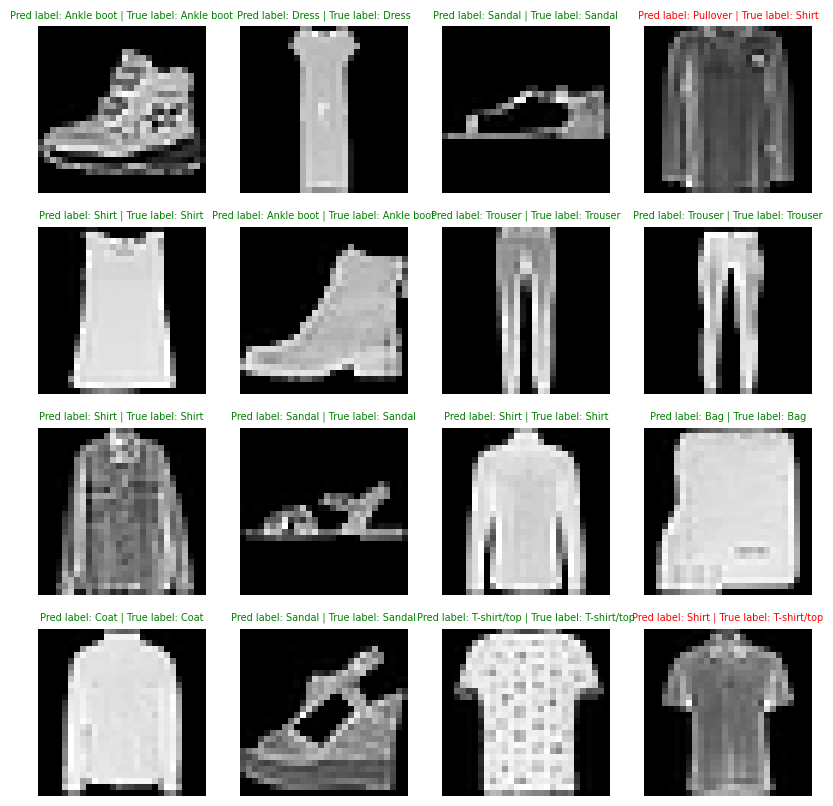

In [48]:
# I'm going to make a plt figure showing the predictions
NROWS = 4
NCOLS = 4
fig = plt.figure(figsize=(10,10))
for num in range(1, NROWS*NCOLS+1):
    no = random.randint(0, len(feature))
    img = feature[no].squeeze()
    true_label = label[no]
    pred_label = preds[no]
    fig.add_subplot(NROWS,NCOLS,num)
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    title_text = f"Pred label: {class_names[pred_label]} | True label: {class_names[true_label]}"
    if pred_label == true_label:
        plt.title(title_text, fontsize=7, c="g")
    else:
        plt.title(title_text, fontsize=7, c="r")
    

It's seems the model can't really differentiate between the classes (Shirt and T-shirt) and (Pullover and shirt)

I'll plot a confusion matrix to visualise this

In [49]:
import torchmetrics, mlxtend

In [ ]:
pred = get_model_results(model=model, dataloader=test_dataloader, loss_fn=loss_fn,acc_fn=acc_fn)


Test loss: 0.28849 | Test accuracy: 89.39%


10000

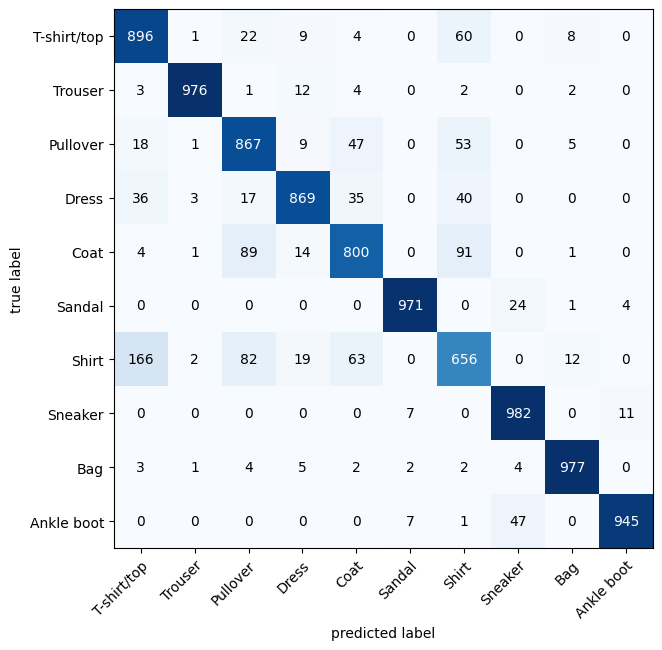

In [56]:
#Plotting the confusion matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds = pred,
                         target=test_data.targets)


# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


We can see our model does fairly well since most of the dark squares are down the diagonal from top left to bottom right (and ideal model will have only values in these squares and 0 everywhere else).

The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt".

And the same for predicting "Shirt" for classes that are actually labelled "T-shirt/top".

This kind of information is often more helpful that a single accuracy metric because it tells use *where* a model is getting things wrong.

It also hints at *why* the model may be getting certain things wrong.

It's understandable the model sometimes predicts "Shirt" for images labelled "T-shirt/top".

We can use this kind of information to further inspect our models and data to see how it could be improved.